In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

##### Using a pre-trained convnet

We use the VGG16 network, trained on ImageNet, to extract features that we use for training a network to recognize painters.

The code is adapted from the notebook 5.3-using-a-pretrained-convnet.ipynb by F. Chollet.
One main difference is that we have three different categories (Monet, Picasso, vanGogh) ind not two as in the original example. This means that we cannot do with a single output node, but use three with a special encoding af the categories as explained below
<br/><br/>
Henning Christiansen, 25/3-2019</br>

VERSION 2: TESTING THE HYPOTHESIS THAT TAKING "LOW-LEVEL" FEATURES FROM THE MIDDLE OF VGG16
    RATHER THAT THE ALMOST TOP LAYERS WILL BE BETTER FOR IDENTIFYING PAINTERS.<br/>
We started out using all features (=results of filters) of the chosen layer, but the number of features were far to big, so the fully connected layers on top had far too many weights, so overfittig was terrible.
To corrects for this, we simply threw away most of the weight -- chosen arbitrarily as there is no obvious way to prefer some filters for others. 



First a little exercise on numpy arrays -- we need to know how to select a subset of filters resulting from a convolutional or maxpooling layer  

In [2]:
### Find out how to chop an np.array
import numpy as np
a = np.array([[ [[10111, 10112, 10113],
        [10121, 10122, 10123],
        [10131, 1012, 1013] ],

       [[10211, 10212, 10213],
        [10221, 10222, 10223],
        [10231, 10232, 10233] ] ],


      [[[20111, 20112, 20113],
        [20121, 20122, 20123],
        [20131, 20132, 20133] ],

       [[20211, 20212, 20213],
        [20221, 20222, 20223],
        [20231, 20232, 20233] ] ] ])
a=a[:,:,:,0:2] ## reducing the last "column" NB: 0:2 gives 2 elements and not 3!!!!!!
a

array([[[[10111, 10112],
         [10121, 10122],
         [10131,  1012]],

        [[10211, 10212],
         [10221, 10222],
         [10231, 10232]]],


       [[[20111, 20112],
         [20121, 20122],
         [20131, 20132]],

        [[20211, 20212],
         [20221, 20222],
         [20231, 20232]]]])

First instantiate the VGG16 model;  we introduce a few symbolic constants that we can use here and leter, in order to make the code easier to read and to modify.

In [3]:
input_width = 250
input_height = 250
input_area = input_width * input_height

from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
               input_shape=(input_width, input_height, 3)) # honestly, I'm not sure whether height or width comes first

conv_base

Comment from original notebook:
<i>We passed three arguments to the constructor:

* `weights`, to specify which weight checkpoint to initialize the model from
* `include_top`, which refers to including or not the densely-connected classifier on top of the network. By default, this 
densely-connected classifier would correspond to the 1000 classes from ImageNet. Since we intend to use our own densely-connected 
classifier (....), we don't need to include it.
* `input_shape`, the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it, 
then the network will be able to process inputs of any size</i>

HC addition: UNFORTUNATELY THE LAST REMARK IS INCORRECT!!!!
It does not work with variable size input, and you need to be consistent with the size you specify in the following.

There is no way to specify which specific layers we want to include; it is either with or without the 3 fully-connected layers at the top of the network (see https://keras.io/applications/#vgg16)


In [4]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 250, 250, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 250, 250, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 250, 250, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 125, 125, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 125, 125, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 125, 125, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 62, 62, 128)       0         
__________

The "Output Shape" of the different layers depends in an undocumented way on the size of the input layer.
We will need them below, so let us (sic!) manually read the constants in the printout above, and remember them as follows.

In [5]:
block3_pool_width = 31
block3_pool_height = 31
block3_pool_area = block3_pool_width * block3_pool_height
block3_pool_no_of_filters = 256

## Following not used, but included for completeness and your own possible experiments
block5_pool_width = 7
block5_pool_height = 7
block5_pool_area = block3_pool_width * block3_pool_height
block5_pool_no_of_filters = 512

Let us now generate new training data, consisting of features generated in a feedforward fashion from
the VGG16 model. Be aware that when we have done that, we do not need VGG16 anymore. We train out own much simpler model from the generated data. However, if we later want to apply our trained model to a specifix image (e.g., a painting that we consider to invest into), we would need VGG16 again -- and it would be nice if we wrote a little function to wrap the details. -- The code below is polished a little from the original, but not generic in the sense that we can apply it for a single image.

In [20]:
import os
import numpy as np
###import tensorflow as tf
from keras import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical ## we need that as our labels cannot be represented by a single output node

base_dir = '/Users/henning/Documents/Kurser/deepLearningSpring2020/PaintingsData/paintings'

train_dir = os.path.join(base_dir, 'train')
total_no_of_training_images = 210  ## Keras seems to lack the ability to count, so we set this manually:
validation_dir = os.path.join(base_dir, 'validation')
total_no_of_validation_images = 60
test_dir = os.path.join(base_dir, 'test')
total_no_of_test_images = 30

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 10  ## arbitrary; I have tried both 10 and 20, but not much difference

## The following is a hack that immitates that we chop off every layer that follows block3_pool
## -- it is unclear whether it calculates all features and output of the model, or it stops when
##    it has found what it needs
## To understand this, lookup Model (spelled with capital M!!) and get_layer in the Keras documentation

intermediate_layer_model = Model(inputs=conv_base.input,
                                 outputs=conv_base.get_layer('block3_pool').output)

## This model produces output consisting of block3_pool_area "image elements" or columns,
## having block3_pool_no_of_filters filters.
## What we will do here is to reduce the number of filters, throwing some of the away
## -- There is no good argument to prefer some filters for others, so we just take the first
##    ones, as determined by the folling constant

###### USE THIS CONSTANT BELOW
no_of_filters_left = 100; ## must be <= block3_pool_no_of_filters

## The reason to do this is that otherwise there are far too many weigths needed to send the
## features (=results of applying filters) into our own fully connected layer explained later.

## Now the function that we use for generating the new training/validation/test data sets from our original images

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, block3_pool_width, block3_pool_height, block3_pool_no_of_filters))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(input_width, input_height),
        batch_size=batch_size,
        class_mode='sparse')   ## NB: the documentation's explanation of class_mode is unclear,
                               ## and the setting 'sparse' has been found by experimentation


    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = intermediate_layer_model.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break

    ### Now throwing away most of the features (= results of features)
    features = features[:,:,:,0:no_of_filters_left]
    ### convert labels 0, 1, and 2 to [1,0,0], [0,1,0] and [0,0,1] 
    labels = to_categorical(labels)
    return features, labels

## Now using the function thus defined
train_features, train_labels = extract_features(train_dir, total_no_of_training_images)

validation_features, validation_labels = extract_features(validation_dir, total_no_of_validation_images)

test_features, test_labels = extract_features(test_dir, total_no_of_test_images)

## This takes terribly long time due to the astronomical number of parameters in VGG16

Found 210 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


The extracted features are currently of multidimensional shape `(samples, block3_pool_area * no_of_filters_left)`.
We "flatten" them so they fit into a Dense layer

In [21]:
train_features = np.reshape(train_features, (total_no_of_training_images, block3_pool_area * no_of_filters_left))
validation_features = np.reshape(validation_features, (total_no_of_validation_images, block3_pool_area * no_of_filters_left))
test_features = np.reshape(test_features, (total_no_of_test_images, block3_pool_area * no_of_filters_left))

At this point, we can define our densely-connected classifier (note the use of dropout for regularization), and train it on the data and 
labels that we just recorded:

In [22]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()

## The no. of nodes is arbitrary; the curves with 100, 150, 256 looks more or less the same.

model.add(layers.Dense(150, activation='relu', input_dim=block3_pool_area * no_of_filters_left))


model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='sigmoid'))  ## HC experiment 3 output nodes instead of 1

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=50,  ## going up to 100 does not change the overall picture
                    batch_size=batch_size,
                    validation_data=(validation_features, validation_labels))

Train on 210 samples, validate on 60 samples
Epoch 1/50
210/210 [==============================] - 9s 43ms/step - loss: 5.3553 - acc: 0.6159 - val_loss: 4.5594 - val_acc: 0.6778
Epoch 2/50
210/210 [==============================] - 7s 34ms/step - loss: 4.5788 - acc: 0.6762 - val_loss: 4.1155 - val_acc: 0.7056
Epoch 3/50
210/210 [==============================] - 7s 32ms/step - loss: 4.6191 - acc: 0.6730 - val_loss: 5.3465 - val_acc: 0.6667
Epoch 4/50
210/210 [==============================] - 7s 33ms/step - loss: 4.1163 - acc: 0.6825 - val_loss: 1.7677 - val_acc: 0.8444
Epoch 5/50
210/210 [==============================] - 7s 32ms/step - loss: 2.8883 - acc: 0.7667 - val_loss: 1.4005 - val_acc: 0.8444
Epoch 6/50
210/210 [==============================] - 7s 31ms/step - loss: 1.9861 - acc: 0.8238 - val_loss: 0.9813 - val_acc: 0.8500
Epoch 7/50
210/210 [==============================] - 7s 31ms/step - loss: 1.3965 - acc: 0.8476 - val_loss: 0.4954 - val_acc: 0.8889
Epoch 8/50
210/210 [====

Training is very fast, since we only have to deal with two `Dense` layers -- ...

Let's take a look at the loss and accuracy curves during training:

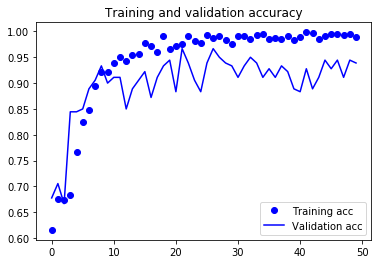

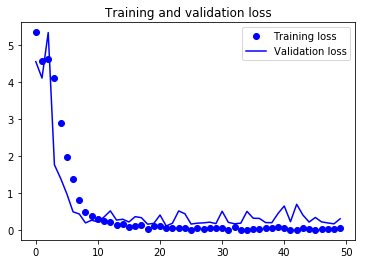

In [23]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Coming back to our hypothesis: <i>"middle layes of VGG16 are better than the almost top layers for painter identification",</i> is not really confirmed.... (compare with the graphs for the first experiment that used almost top layers)

In [ ]:
model.summary()